In [1]:
#from helper import IMAGE_RES
IMAGE_RES = 100

In [2]:
import os
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from helper import build_directory_lookup, get_subdirectory
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
)
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [3]:
# training

# define the subdirectory where you training data is located
training_sub = "data/train"
testing_sub = "data/test"

training_path = get_subdirectory(training_sub)
validation_path = get_subdirectory(testing_sub)
directory_lookup, directory_reverse_lookup = build_directory_lookup(training_path)

file_name = "directory_reverse_lookup_train.json"
# Save the dictionary to a JSON file
with open(file_name, "w") as json_file:
    json.dump(directory_reverse_lookup, json_file)


print(directory_lookup)
print("--------------------------")
print(directory_reverse_lookup)

Current Directory: c:\Users\navee\Projects\Brain AI Project
Current Directory: c:\Users\navee\Projects\Brain AI Project
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
--------------------------
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,  #normalize pixel values to be between 0 and 1
    #horizontal_flip=True,  #randomly flip images horizontally
    #validation_split=0.3 # set data split
)

target_size = (IMAGE_RES, IMAGE_RES)  
batch_size = 32

In [5]:
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
    #subset="training", 
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
    #subset="validation",  #
)

class_names = os.listdir(training_path)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
num_rows = 3  
num_cols = (len(class_names) + num_rows - 1) // num_rows

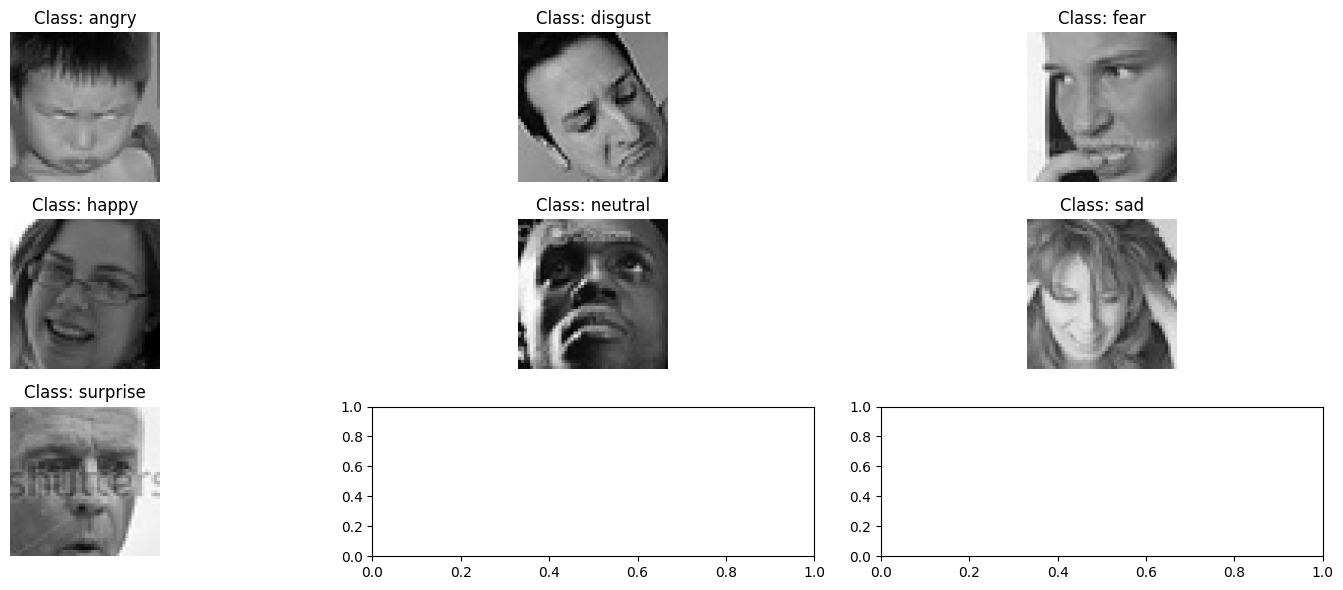

In [7]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))


for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_path, class_name)

    image_files = [
        f for f in os.listdir(class_path) if f.endswith(".jpg") or f.endswith(".png")
    ]

    img_path = os.path.join(class_path, image_files[0])
    img = image.load_img(img_path, target_size=target_size)
    axs[i // num_cols, i % num_cols].imshow(img)
    axs[i // num_cols, i % num_cols].set_title(f"Class: {class_name}")
    axs[i // num_cols, i % num_cols].axis("off")


plt.tight_layout()


plt.show()

In [8]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
file_name = "data_lookup_train.json"

with open(file_name, "w") as json_file:
    json.dump(class_indices, json_file)


print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_validation_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {class_indices}")

Number of training samples: 28709
Number of validation samples: 7178
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [9]:
def build_model(hp):
    model = keras.Sequential()

    num_conv_layers = hp.Int("num_conv_layers", min_value=1, max_value=5)
    num_dense_layers = hp.Int("num_dense_layers", min_value=1, max_value=3)

    model.add(
        Conv2D(
            filters=hp.Int("conv_1_filter", min_value=4, max_value=256, step=4),
            kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
            activation="relu",
            input_shape=(IMAGE_RES, IMAGE_RES, 3),
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    for i in range(num_conv_layers - 1):  # Adjust range for excluding first layer
        model.add(
            Conv2D(
                filters=hp.Int(
                    f"conv_{i+2}_filter", min_value=4, max_value=256, step=4
                ),
                kernel_size=hp.Choice(f"conv_{i+2}_kernel", values=[3, 5]),
                activation="relu",
            )
        )
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    for i in range(num_dense_layers):
        model.add(
            Dense(
                units=hp.Int(f"dense_{i+1}_units", min_value=1, max_value=150, step=4),
                activation="relu",
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(f"dropout_{i+1}", min_value=0.2, max_value=0.5, step=0.1)
            )
        )

    # Output layer
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [10]:
tuner = Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=2,
    directory="search",
    project_name="emotion_detection",
)

In [11]:


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1


early_stopping = EarlyStopping(patience=8, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)


tuner.search(
    train_generator,
    epochs=15,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks=[lr_schedule,early_stopping],
)





Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_conv_layers
3                 |3                 |num_dense_layers
168               |168               |conv_1_filter
5                 |5                 |conv_1_kernel
45                |45                |dense_1_units
0.3               |0.3               |dropout_1
1e-05             |1e-05             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
897/897 [==============================] - 526s 585ms/step - loss: 1.9448 - accuracy: 0.2507 - val_loss: 1.9437 - val_accuracy: 0.2473 - lr: 1.0000e-05
Epoch 2/2
121/897 [===>..........................] - ETA: 7:15 - loss: 1.9437 - accuracy: 0.2451

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.results_summary()

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.values} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
"""
)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_generator
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_schedule, early_stopping],
)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))